# Sentiment Analysis

Using get_comments_from_video.py, I was able to collect more than 500k comments off Blackpink's latest music video "How You Like That". Now, we'll follow some classical preprocessing techniques to get our texts ready for sentiment analysis.

Determine what language a given text is. Preprocessing techniques that work on English won't work on Chinese.

Tiago: pre-tokenization and post-tokenization steps. Following this framework:

Pre-tokenization steps:
1. Remove URLs
2. Handle emojis: add whitespace between consecutive emojis, etc.

Post-tokenization steps:
1. Remove 
3. some kind of text normalization (lowercase, etc.)
4. handle contractions

Now unlike usually text preprocessing, we actually don't want to remove emojis. This is because emojis are another type of data that we can perform sentiment analysis on. Since these comments are from social media, we're bound to have a lot of misspellings and emojis. We'd be losing out on data if we were to remove these.

Post-tokenization:
1. remove punctuation


Where we are now:
Just got translations for non-English sentences, and labeled each sentence as a language or as Emoji.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import regex
import spacy
import emoji
import dateutil.parser

from util import get_results_of_comparison
%matplotlib inline

ModuleNotFoundError: No module named 'regex'

In [1]:
# import our data 
blackpink = pd.read_csv('comments_by_time_june27_july08.csv', lineterminator='\n')

NameError: name 'pd' is not defined

In [13]:
# this allows us to convert time as YouTube stores it (ISO 8601)
def parse_yt_datetime(date):
    return dateutil.parser.parse(date)

In [9]:
blackpink['Updated At'] = blackpink['Updated At'].apply(lambda x: parse_yt_datetime(x))

blackpink.head(10)

In [12]:
blackpink.to_csv("python_datetime_june27_july08.csv", index=False)

In [14]:
blackpink.keys()

Index(['Comment', 'Comment ID', 'Replies Count', 'Like Count', 'Updated At'], dtype='object')

In [18]:
print(blackpink.shape)
print("Remember that we removed duplicates based on comment ID, so")

(490753, 5)
Remember that we removed duplicates based on comment ID, so


In [17]:
unique_comments = Counter(blackpink['Comment ID'])
print(len(unique_comments))

490753


Seems like we have a few duplicate comments. However, we may or may not need to write these off: after all, sometimes fans may just duplicate comments in support of their group. We can expect many fans to simply write, "I love Blackpink!" for example.

# Step one: remove urls

In [77]:
# https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
# remove urls
# re.sub(r'https?://\S+', '', 'https://hello')
# .apply(lambda x: x + pd.offsets.QuarterEnd(0))

def remove_urls(text):
    return re.sub(r'https?://\S+', '', text)

In [78]:
stripped_urls = [remove_urls(comment) for comment in blackpink['Comment'].values]

In [79]:
nonstripped = [comment for comment in blackpink['Comment'].values]

count = 0
for comment in nonstripped:
    if 'http' in comment:
        count += 1


print(count) # 158 comments w/ links that we cleaned

158


In [80]:
blackpink['Stripped Urls'] = stripped_urls

# Step two: taking care of emojis

Like we said, we're not going to remove emojis. And unfortunately, the sentiment analysis library I plan on using, vader sentiment, doesn't understand more contemporary understanding of emojis. For example:

In [82]:
analyzer = SentimentIntensityAnalyzer()

In [88]:
print(analyzer.polarity_scores("🤮"))

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [89]:
print(analyzer.polarity_scores("👑"))

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [90]:
print(analyzer.polarity_scores("🔥"))

{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.34}


It doesn't recognize 🤮 as a negative emoji, doesn't recognize 👑 as a positive emoji, and misclassifies 🔥 as negative when it has a positive connotation on social media.

So, let's manually classify emojis.

In [102]:
def get_emojis(text):
    just_emojis = ""
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            just_emojis += word
    return Counter(just_emojis)

print(get_emojis("Jennie with short ugh I LOVE ITTT!😍😍😍"))

Counter({'😍': 3})


In [105]:
all_emojis = Counter(get_emojis("".join(stripped_urls)))

In [107]:
len(all_emojis)

552

In [127]:
for emoji_char, count in all_emojis.items():
    if emoji_char in skrt:
        vs = analyzer.polarity_scores(skrt[emoji_char])
    else:
        vs = analyzer.polarity_scores(emoji_char)
    print('-'*80)
    print(emoji.demojize(emoji_char), emoji_char, count)
    print(vs)
    print('='*80)

--------------------------------------------------------------------------------
:face_with_tears_of_joy: 😂 985
{'neg': 0.218, 'neu': 0.345, 'pos': 0.437, 'compound': 0.4404}
--------------------------------------------------------------------------------
:red_heart: ❤ 2991
{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}
--------------------------------------------------------------------------------
 ️ 2056
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
--------------------------------------------------------------------------------
:face_with_monocle: 🧐 43
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.3182}
--------------------------------------------------------------------------------
:two_hearts: 💕 590
{'neg': 0.0, 'neu': 0.189, 'pos': 0.811, 'compound': 0.6486}
--------------------------------------------------------------------------------
:grinning_face_with_smiling_eyes: 😄 110
{'neg': 0.0, 'neu': 0.353, 'pos': 0.647, 'compound': 0.6705}
--------------

:watermelon: 🍉 35
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
--------------------------------------------------------------------------------
:green_apple: 🍏 3
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
--------------------------------------------------------------------------------
:duck: 🦆 3
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
--------------------------------------------------------------------------------
:beverage_box: 🧃 3
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
--------------------------------------------------------------------------------
:upside-down_face: 🙃 84
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
--------------------------------------------------------------------------------
:up_arrow: ⬆ 23
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
--------------------------------------------------------------------------------
:tangerine: 🍊 3
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
--------------

--------------------------------------------------------------------------------
:weary_cat_face: 🙀 12
{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'compound': -0.2732}
--------------------------------------------------------------------------------
:cherries: 🍒 35
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
--------------------------------------------------------------------------------
:direct_hit: 🎯 5
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
--------------------------------------------------------------------------------
:up-right_arrow: ↗ 3
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
--------------------------------------------------------------------------------
:right-facing_fist: 🤜 2
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
--------------------------------------------------------------------------------
:trophy: 🏆 4
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
---------------------------------------------------------------------

--------------------------------------------------------------------------------
:joystick: 🕹 2
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.1779}
--------------------------------------------------------------------------------
:chess_pawn: ♟ 1
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
--------------------------------------------------------------------------------
:ear_with_hearing_aid: 🦻 1
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
--------------------------------------------------------------------------------
:boy: 👦 1
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
--------------------------------------------------------------------------------
:nose: 👃 2
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
--------------------------------------------------------------------------------
:play_button: ▶ 1
{'neg': 0.0, 'neu': 0.294, 'pos': 0.706, 'compound': 0.34}
--------------------------------------------------------------------------------
:mo

# Looks like we've got 552 emojis to label!!!

Out of the list, we'll redefine the below and create a new dictionary out of it. Then, we'll drop all emojis with a count less than 10.

Some that can be very ambiguous, such as '🤔', I decided to just leave them be. Or animal faces, like frog_face, pig_face, ... left those.
Others fell below cutoff: double_exclamation_mark, funeral_urn, hot_pepper
Others, collision, fire, we gave it word equivalent.


In [382]:
with open('redefined.json', 'r') as fp:
    redefined_meaning = json.load(fp)


In [383]:
redefined_meaning['🔥']

'_great!'

In [384]:
def replace_emojis_or_word(text, redefined_meaning):
    new_text = []
    text = re.split(r'(\s+)', text)
    
    for word in text:
        has_emoji = False
        idx_begin = 0
        for idx_end, letter in enumerate(word):
            if any(char in emoji.UNICODE_EMOJI for char in letter):
                # append non-emoji text
                new_text += redefined_meaning.get(word[idx_begin:idx_end], word[idx_begin:idx_end]) + ' '
                # set new head to one after current idx_end
                idx_begin = idx_end + 1

                # add the emoji we just found
                new_text += redefined_meaning.get(letter, letter) + ' '
                has_emoji = True

        if not has_emoji:
            new_text += redefined_meaning.get(word, word)

    return ''.join(new_text)



In [385]:
replace_emojis_or_word('Owh my goot lisa- its sou beautiful😮😮😮', redefined_meaning)

'Owh my goot lisa- its sou beautiful 😮  😮  😮 '

In [386]:
blackpink['Modified Emojis and Words'] = [replace_emojis_or_word(comment, redefined_meaning) for comment in stripped_urls]


# Now let's get comments specific to the four members

In [387]:
only_jennie = blackpink['Comment'].str.contains("jennie|제니", case=False) & \
~blackpink['Comment'].str.contains("rosé|rose|lisa|jisoo|로제|지수|리사", case=False) 

only_jisoo = blackpink['Comment'].str.contains("jisoo|지수", case=False) & \
~blackpink['Comment'].str.contains("rosé|rose|lisa|jennie|로제|제니|리사", case=False)

only_rose = blackpink['Comment'].str.contains("rose|로제", case=False) & \
~blackpink['Comment'].str.contains("jennie|lisa|jisoo|지수|제니|리사", case=False) 

only_lisa = blackpink['Comment'].str.contains("lisa|리사", case=False) & \
~blackpink['Comment'].str.contains("rosé|rose|jennie|jisoo|지수|제니|로제", case=False)


In [388]:
print(blackpink[only_jennie].shape, 
      blackpink[only_jisoo].shape, 
      blackpink[only_rose].shape, 
      blackpink[only_lisa].shape, 
      blackpink.shape)

(257, 11) (258, 11) (126, 11) (551, 11) (14703, 11)


In [389]:
mask, pos, preprocessed_jennie_english = get_results_of_comparison("English", "Expanded Language Name",
                                                     "Modified Emojis and Words", blackpink[only_jennie])
mask, pos, preprocessed_jisoo_english = get_results_of_comparison("English", "Expanded Language Name",
                                                     "Modified Emojis and Words", blackpink[only_jisoo])

mask, pos, preprocessed_rose_english = get_results_of_comparison("English", "Expanded Language Name",
                                                     "Modified Emojis and Words", blackpink[only_rose])

mask, pos, preprocessed_lisa_english = get_results_of_comparison("English", "Expanded Language Name",
                                                     "Modified Emojis and Words", blackpink[only_lisa])

In [390]:
print(len(jennie_english),
      len(jisoo_english),
      len(rose_english), 
      len(lisa_english) )  

print("percentage of english comments for Jennie:", len(jennie_english) / len(blackpink[only_jennie]))
print("percentage of english comments for Jisoo:", len(jisoo_english)  / len(blackpink[only_jisoo]))
print("percentage of english comments for Rose:", len(rose_english)   / len(blackpink[only_rose]))
print("percentage of english comments for Lisa:", len(lisa_english)   / len(blackpink[only_lisa]))

207 133 105 375
percentage of english comments for Jennie: 0.8054474708171206
percentage of english comments for Jisoo: 0.5155038759689923
percentage of english comments for Rose: 0.8333333333333334
percentage of english comments for Lisa: 0.6805807622504537


# Step 3
Handling punctuations, symbols, without erasing all emojis

In [391]:
def strip_symbols(text):
    
    # https://stackoverflow.com/questions/58833864/python-regex-removing-all-special-characters-and-numbers-not-attached-to-words
    return ''.join(re.findall(r'(?:[^\W\d_]+\d|\d+[^\W\d_])[^\W_]*|[^\W\d_]+', text))


In [392]:
strip_symbols("**Hello there beautiful😮😮😮")

'Hellotherebeautiful'

In [393]:
def keep_emojis_strip_symbols(text):
    stripped = []
    
    text_to_words = text.split()
    for word in text_to_words:
        data = regex.findall(r'\X', word)
        has_emoji = False
        the_emoji = []
        for char_combo in data:
            if any(char in emoji.UNICODE_EMOJI for char in char_combo):
                has_emoji = True
                break
            else:
                continue
                
        # after analyzing the characters of a word
        if has_emoji:
            stripped.append(''.join(word))
        else:
            stripped.append(strip_symbols(word))
    return ' '.join(stripped)

In [394]:
keep_emojis_strip_symbols("owh my goot lisa its sou beautiful 😮 😮 😮")


'owh my goot lisa its sou beautiful 😮 😮 😮'

In [ ]:
nlp = spacy.load('en_core_web_md')

In [396]:
def clean_comments(document):
    cleaned = []
    for comment in nlp.pipe(document, disable=['parser']):
        sentence = [keep_emojis_strip_symbols(word.lemma_) \
                    if word.lemma_ != '-PRON-' else word.text \
                    for word in comment]
        cleaned.append(' '.join(sentence))
    return cleaned

In [397]:
cleaned_jennie_english = clean_comments(preprocessed_jennie_english)
cleaned_jennie_sentiment = [analyzer.polarity_scores(doc)['compound'] for doc in cleaned_jennie_english]

cleaned_jisoo_english = clean_comments(preprocessed_jisoo_english)
cleaned_jisoo_sentiment = [analyzer.polarity_scores(doc)['compound'] for doc in cleaned_jisoo_english]

cleaned_rose_english = clean_comments(preprocessed_rose_english)
cleaned_rose_sentiment = [analyzer.polarity_scores(comment)['compound'] for comment in cleaned_rose_english]

cleaned_lisa_english = clean_comments(preprocessed_lisa_english)
cleaned_lisa_sentiment = [analyzer.polarity_scores(comment)['compound'] for comment in cleaned_lisa_english]

In [401]:
def compare_diffs(cleaned_comments, orig_comments, cleaned_sent, orig_sent, indices):
    agree = 0
    disagree = 0
    for i in indices:
        if cleaned_sent[i] != orig_sent[i]:
            disagree += 1
            print(cleaned_sent[i], ":", orig_sent[i])
            print(cleaned_comments[i])
            print(orig_comments[i])
            print()
        else:
            agree += 1
    print(agree, disagree)
    

In [402]:
jennie_sentiment = [analyzer.polarity_scores(doc)['compound'] for doc in jennie_english.tolist()]

In [403]:
compare_diffs(cleaned_jennie_english, jennie_english.tolist(), 
              cleaned_jennie_sentiment, jennie_sentiment, [i for i in range(len(cleaned_jennie_english))])

-0.8317 : 0.4184
 no one love JENNIE  JENNIE SUCKS  
*NO ONE LOVES JENNIE! JENNIE SUCKS!*

0.296 : 0.1027
My brain  you be tired  go get some sleep  Jennie  you gon  like that that that that  Me  apologise to my brain 
My brain: you’re tired, go get some sleep 
Jennie: you gon’ like that that that that
Me: apologises to my brain...

0.331 : 0.3832
do you see jennie wear chanel hahaha she s so obsessed in chanel
Do you see jennie wearing chanel hahaha shes so obsessed in chanel

0.2263 : 0.0
I be not a blink  but this song slap  edit  BTW JENNIE slay IT OMFG
I'm not a blink, but this song slaps

Edit: BTW JENNIE SLAYED IT OMFG

-0.6486 : -0.3612
Kaachi must be regret themselves from say jennie be lazy
Kaachi must be regreting themselves from saying jennie is lazy

-0.128 : -0.4824
JENNIE with short hair just hit different DSDKhdhSJD if we be allow to comment with emojis  she be the fire EMOJI with that hair
JENNIE WITH SHORT HAIR JUST HITS DIFFERENT DSDKhdhSJD IF WE WERE ALLOWED TO COMM

[Text(0.5, 0, 'Lisa')]

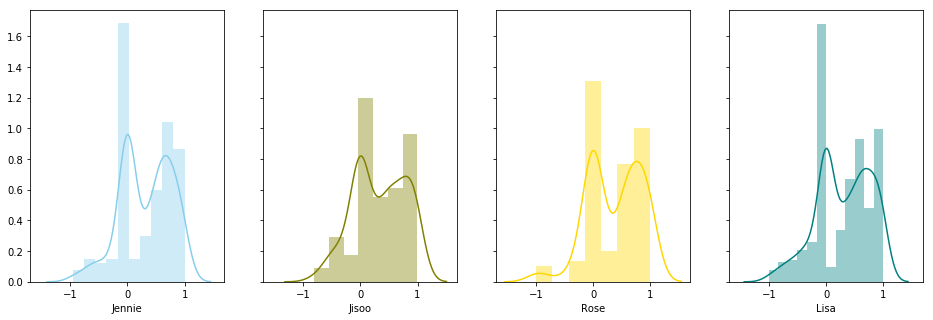

In [404]:
f, axes = plt.subplots(1, 4, figsize=(16, 5), sharex=True, sharey=True)
sns.distplot(cleaned_jennie_sentiment , color="skyblue", ax=axes[0])
sns.distplot(cleaned_jisoo_sentiment, color="olive", ax=axes[1])
sns.distplot(cleaned_rose_sentiment , color="gold", ax=axes[2])
sns.distplot(cleaned_lisa_sentiment , color="teal", ax=axes[3])

axes[0].set(xlabel='Jennie')
axes[1].set(xlabel='Jisoo')
axes[2].set(xlabel='Rose')
axes[3].set(xlabel='Lisa')

In [405]:
positive, negative, neutral = 0, 0, 0
for sentiment, comment in zip(cleaned_lisa_sentiment, lisa_english.tolist()):
    if .05 < sentiment < 1:
        positive += 1
    elif -0.05 < sentiment < 0.05:
        neutral += 1
    else:
        negative += 1

In [406]:
print(positive, negative, neutral)

218 55 102


After all of that, I guess there wasn't much of a difference. It's interesting to note how many "neutral" comments there are. But a quick look at some of the comments in each category show that there are quite a few misclassified comments.

In [416]:
for sentiment, comment in zip(cleaned_lisa_sentiment, lisa_english.tolist()):
    if 0.9 < sentiment <= 1:
        print(sentiment, ':', comment)
        print('-'*80)

0.9996 : I love you lisa 😭😭😭😭😭💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖💖
--------------------------------------------------------------------------------
0.9682 : Lisa so fine and swag! 💕💕💕😍😍
--------------------------------------------------------------------------------
0.9821 : To all the Hindu BLINKs:
I know some of you might find it disrespectful that they put lord Ganesh on the floor, (1:20) but here are some things I would like to say:

1) you cannot completely see if it is on the floor. My mother worships lord Ganesha but since we have a small place to set up the statues we have to keep the statue on a small stool . But we mean no disrespect. The same thing could happen in the MV.

2) if you believe in God then you should know that God doesn't exist in things like statues. The statue was made out of iron/ clay / wood. But do you think God will live in wood, clay,iron ? No. You should believe that God is always by your side.

3) some people don't believe in God. You might say that even if 

In [380]:
redefined = {
    '👑': '_best',
    '🧐': '_skeptical',
    '💩': '_shit',
    '🌷': '_beautiful',
    '🌹': '_affection',
    '👍': '_good',
    '🤪': '_crazy',
    '💅': '_indifferent',
    '🙉': '_amuse',
    '🙄': '_disappoint',
    '🔥': '_great!',
    '👏': '_applause',
    '😒': '_not amused',
    '😝': '_playful',
    '💔': '_sad', 
    '😋': '_delicious',
    '🤢': '_bad',
    '👎': '_bad',
    '👸': '_good',
    '🌼': '_appreciate',
    '🖕': '_bad',
    '✊': '_good',
    '😑': '_bored',
    '🌝': '_irony',
    '🤩': '_wow',
    '💯': '_great',
    '🤮': '_disgust',
    '🙂': '_satisfied',
    '🥱': '_bored',
    '😪': '_tired',
    '😣': '_frustration',
    '😜': '_fun',
    '🙈': '_oh my god',
    '😳': '_surprise',
    '🤷': '_indifference',
    '🥺': '_please',
    '🤬': '_curse',
    '🥵': '_sexy',
    '🌟': '_brilliant',
    '👁👄👁': '_confuse',
    '🤯': '_wow',
    '🤡': '_fool',
    '😆': '_haha',
    '😷': '_sick',
    '✔️': '_approval',
    '🤟': '_love',
    '🤨': '_skeptical',
    '😏': '_satisfaction',
    '🌚': '_ironic',
    '😐': '_irritation',
    '💄': '_glamour',
    '😖': '_frustrate',
    '🎊': '_congratulations',
    '😜': '_playful',
    '😡': '_anger',
    '😯': '_surprise',
    '🤭': '_shock',
    '🙃': '_frustration',
    '👊': '_celebrate',
    '💪': '_strong',
    '😶': '_awkward',
    '😥': '_sad',
    '🤤': '_yummy',
    '🤍': '_heart',
    '✔️': '_good',
    '😤': '_pride',
    '💥': '_wow',
    '🙏': '_blessing',
    '💣': '_amazing',
    '💫': '_great',
    '🤧': '_good',
    '💀': '_shock',
    'kill': '_great',
    'killed': '_great',
    'killing': '_great',
    '😂': '_obnoxious'
        
}

In [381]:
import json
with open('redefined.json', 'w') as fp:
    json.dump(redefined, fp)


In [7]:
import time

In [43]:
begin = time.process_time()
using_values = [comment for comment in blackpink['Comment'].values]
elapsed_time = time.process_time() - begin

In [44]:
print(elapsed_time)

0.0037570000000002324


In [16]:
print(len(using_values))

14703


In [51]:
begin = time.process_time()
using_values = [comment for comment in blackpink['Comment']]
elapsed_time = time.process_time() - begin

In [52]:
print(elapsed_time)

0.005006999999999984


In [56]:
print(using_values[2])

https://www.youtube.com/watch?v=abPiBoRJeQo
